# Laboratorio 1 - Grupo 18 - Equipo 2

### Para el laboratorio 1 de la asignatura de Percepción Computacional, se ha desarrollado una función que permite eliminar el artefacto de "ojos rojos" de una fotografía. 

La corrección se realiza detectando los ojos de la persona en la foto. Una vez detectados, se compara el valor de cada pixel de la zona "ojos" del canal rojo con la media de los valores de los canales azul y verde. Si este ratio es mayor que un umbral, se reduce el valor de intensidad del canal rojo.

En el caso de que se quiera aplicar la función a una imagen de un animal cuyos ojos no se parecen a los humanos (p.ej. un gato) o el algoritmo de detección de ojos falle en una determinada imagen, se puede probar a utilizar una función alternativa (con el parámetro modo_manual en TRUE) que reducirá el valor de intensidad del canal rojo para una región de interés seleccionada de forma manual por el usuario.

Implementación inspirada en [1] con funcionalidad mejorada y cambios en la implementación.

Este Notebook está publicado en GitHub [https://github.com/franciscocobo/Lab1-percepcioncomputacional](https://github.com/franciscocobo/Lab1-percepcioncomputacional) y en Colab [https://colab.research.google.com/github/franciscocobo/Lab1-percepcioncomputacional/blob/main/Lab1_Grupo18_Equipo2.ipynb](https://colab.research.google.com/github/franciscocobo/Lab1-percepcioncomputacional/blob/main/Lab1_Grupo18_Equipo2.ipynb). 

Librerías necesarias:

In [22]:
import numpy as np
import cv2
import dlib
import site
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path

#### Para utilizar la función, se debe crear una instancia de la clase OjosRojos, proporcionando como parámetro la ruta en la que se encuentra la imagen. Después, se podrán usar las funciones para realizar la transformación o visualizar distintos elementos

In [3]:
class OjosRojos:
    '''A las instancias de esta clase, se les puede aplicar una transformación para corregir el artefacto de ojos rojos   
    Funciones
    ---------
    - corregir_rojo : corregir ojos rojos, devuelve np.array en RGB
    - detectar_ojos : detectar ojos humanos, devuelve posiciones de los ojos
    - ver_roi : ver visualmente la posición de los ojos en la imagen (plot)
    - corregir_manual : corregir el rojo de un ROI seleccionado por el usuario, en caso que falle la detección automática, devuelve np.array en RGB
    - comparar : ver visualmente la imagen sin corregir al lado de la corregida (plot)
    '''
    
    def __init__(self, ruta: str):
        '''Función de inicialización de la clase OjosRojos       
        Parámetros
        ----------
        ruta: path en el que se encuentra la imagen, str
        '''      
        self.im_path = ruta
        
        
    def corregir_rojo(self):
        '''Función que corrige ojos rojos en una imagen
        Devuelve
        --------
        imagen_corregida       
        Llama a la función detectar_ojos
        '''

        #Importar imagen
        img = cv2.imread(self.im_path)
        #llamar a la función que detecta los ojos
        ojos = self.detectar_ojos(img)
        #inicializar imagen_corregida
        imagen_corregida = img
        
        #Si se han encontrado ojos
        if np.any(ojos):
            #corregir balances para cada ojo detectado
            for ojo in ojos:
                inicial_x = ojo[0]
                inicial_y = ojo[1]
                
                #iterar por los pixeles del ojo actual
                for delta in range(ojo[2]):
                    pos_x = inicial_x + delta

                    for delta2 in range(ojo[3]):
                        pos_y = inicial_y + delta2

                        #Condicion para evitar division por cero
                        if ((int(img[pos_y][pos_x][0]) + int(img[pos_y][pos_x][1])) / 2) >0 :
                            #Calculo de la relacion de los tres canales
                            ratio = img[pos_y][pos_x][2] / ((int(img[pos_y][pos_x][0]) + int(img[pos_y][pos_x][1])) / 2) #canal R / la media de B y G
                            
                            if ratio >=2:
                                #Correccion del canal R
                                imagen_corregida[pos_y][pos_x][2] = (int(img[pos_y][pos_x][0]) + int(img[pos_y][pos_x][1])) / 2

        else:
            #Si no hay ojos humanos
            print("No se han detectado ojos. Puede intentar aplicar la función corregir_manual")
            
        return cv2.cvtColor(imagen_corregida,cv2.COLOR_BGR2RGB)
    
    def detectar_ojos(self, imagen):
        '''Función que detecta la posición de los ojos en una imagen

        Parámetros
        ----------
        imagen: matriz CV_8U

        Devuelve
        --------
        ojos: ROI, [[x, y, width, height]]'''

        #archivos xml con el entrenamiento para detectar ojos
        eye_cascade = cv2.CascadeClassifier(os.path.join(os.path.dirname(cv2.__file__), 'data', 'haarcascade_eye.xml'))

        #convertir imagen a escala de grises para la detección
        gray = cv2.cvtColor(imagen,cv2.COLOR_BGR2GRAY)

        #detectar ojos. Parámetros: imagen, scaleFactor, minNeighbors 
        ojos = eye_cascade.detectMultiScale(gray, 1.3, 5)

        return ojos
    
    def ver_roi(self):
        '''Función para comprobar que los ROI sobre los que se está aplicando la tranformación de ojos rojos son correctos
        
        Llama a la función detectar_ojos'''
        
        #Importar imagen
        img = cv2.imread(self.im_path)

        #llamar a la función que detecta los ojos
        ojos = self.detectar_ojos(img)
        
        if np.any(ojos):
            for ojo in ojos:
                #Para ver los ROI de los ojos
                cv2.line(img,(ojo[0],ojo[1]),(ojo[0]+ojo[2],ojo[1]),(255,0,0),5)
                cv2.line(img,(ojo[0]+ojo[2],ojo[1]),(ojo[0]+ojo[2],ojo[1]+ojo[3]),(255,0,0),5)
                cv2.line(img,(ojo[0]+ojo[2],ojo[1]+ojo[3]),(ojo[0],ojo[1]+ojo[3]),(255,0,0),5)
                cv2.line(img,(ojo[0],ojo[1]+ojo[3]),(ojo[0],ojo[1]),(255,0,0),5)
                cv2.imwrite("roi.jpg",img)
                
            plt.imshow(img);
        
        else:
            print("No se han detectado ojos")           
    
    def corregir_manual(self):
        '''Función que corrige el canal rojo en una imagen en una región particular de interés seleccionada manualmente por el usuario
           Utilizar para imágenes de animales o cuando corregir_rojo no funciona correctamente.
           Para seleccionar el ROI, se deberá hacer click izquierdo del ratón sobre la ventana emergente que aparecerá con la imagen,
           y arrastrarlo hasta que el rectángulo azul cubra toda la zona que se desea cambiar. En caso de querer borrar la selección 
           para coger otra, se puede hacer volviendo a repetir este paso. Una vez escogido el ROI, se debe pulsar el botón enter
           para aplicar la corrección.

        Devuelve
        --------
        imagen_corregida
        '''

        #Importar imagen
        img = cv2.imread(self.im_path)  
        #inicializar imagen_corregida
        imagen_corregida = img
        
        print("Por favor seleccione con rectángulos azules las zonas de la imagen donde se encuentran los ojos (click izquierdo y arrastrar). \n \
        Tras seleccionar cada ojo, presione la tecla enter. Cuando termine de seleccionar, presione escape.")
        
        # Seleccionar ROI
        ojos = cv2.selectROIs("Press esc to finish", img)
        cv2.destroyAllWindows()
        
        if np.any(ojos):
            #corregir balances para cada ojo detectado
            for ojo in ojos:
                inicial_x = ojo[0]
                inicial_y = ojo[1]

                #iterar por los pixeles del ROI
                for delta in range(ojo[2]):
                    pos_x = inicial_x + delta

                    for delta2 in range(ojo[3]):
                        pos_y = inicial_y + delta2

                        #Condicion para evitar division por cero 
                        if ((int(img[pos_y][pos_x][0]) + int(img[pos_y][pos_x][1])) / 2) >0 :
                            #Calculo de la relacion de los tres canales
                            ratio = img[pos_y][pos_x][2] / ((int(img[pos_y][pos_x][0]) + int(img[pos_y][pos_x][1])) / 2) #canal R / la media de B y G

                            if ratio >=2:
                                #Correccion del canal R
                                imagen_corregida[pos_y][pos_x][2] = (int(img[pos_y][pos_x][0]) + int(img[pos_y][pos_x][1])) / 2

        return cv2.cvtColor(imagen_corregida,cv2.COLOR_BGR2RGB)
 
    def comparar(self, modo_manual=False):
        '''Función que muestra la imagen corregida y la imagen sin corregir en un plot de matplotlib
        
        Llama a la función corregir_rojo
        '''
        #imagenes:        
        imagen_original = cv2.cvtColor(cv2.imread(self.im_path),cv2.COLOR_BGR2RGB)
        if modo_manual:
            imagen_corregida = self.corregir_manual()
        else:
            imagen_corregida = self.corregir_rojo()
         
        #gráfica
        fig, ax = plt.subplots(1, 2, figsize = (10,5))

        ax[0].imshow(imagen_original)
        ax[1].imshow(imagen_corregida)

        ax[0].set_title('Imagen original', fontsize=30)
        ax[1].set_title('Imagen corregida', fontsize=30);


### Imágenes de prueba

#### Imagen 1

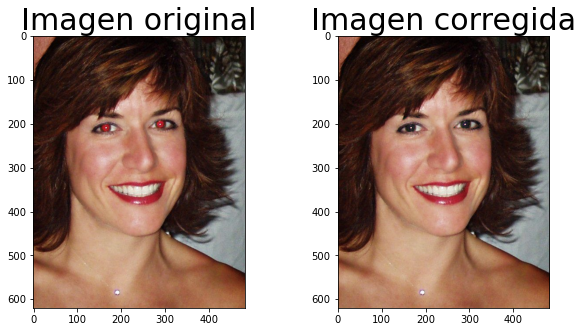

In [4]:
OjosRojos('ojos_rojos1.jpg').comparar()

#### Imagen 2

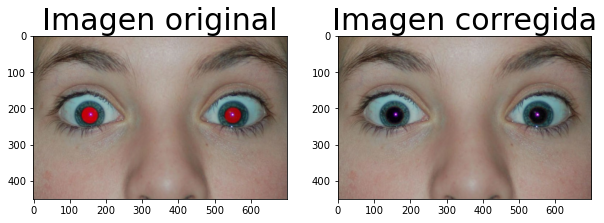

In [5]:
OjosRojos('ojos_rojos2.jpg').comparar()

Usando el programa GIMP2 se han generado estas imágenes, en las que se muestra: 
(1) histograma del canal rojo del ojo sin corregir (2)  histograma del canal rojo del ojo corregido (3) histograma del canal rojo sin corregir eliminando de forma manual píxeles rojos hasta la anomalía detectada (4) histograma del canal rojo sin corregir eliminando de forma manual píxeles rojos y la anomalía detectada.
Lo que se observa, es lo siguiente: las gráficas (1) y (2) son similares salvo en los extremos. Fijándose en la parte derecha de la gráfica (1), se ve que aparece un pico que no aparece en (2). Por ello, si se eliminan píxeles rojos y se comparan dichas imágenes, como se hace en (3) y en (4), se puede obtener de conclusión que el color rojo de la pupila se debe a ese pico, cuyas coordenadas en el eje de abscisas abarcan del 175 al 205.  De esta manera, con el ratio que se utiliza en el código, se pretenden eliminar estos picos de esa zona del eje para la región de interés seleccionada, de forma que se consiga eliminar el color rojo de los ojos.

<img src="histogramasojos.png">

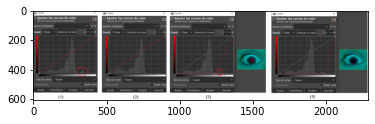

In [23]:
img = mpimg.imread('histogramasojos.png')
imgplot = plt.imshow(img)
plt.show()

In [31]:
im = cv2.cvtColor('histogramasojos.png',cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax[0].imshow(im)


TypeError: Expected Ptr<cv::UMat> for argument 'src'

#### Imagen 3

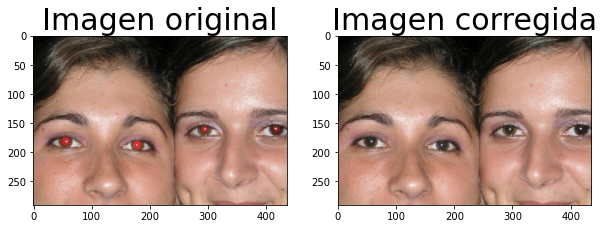

In [6]:
OjosRojos('ojos_rojos5.jpg').comparar()

#### Imagen sin ojos

No se han detectado ojos. Puede intentar aplicar la función corregir_manual


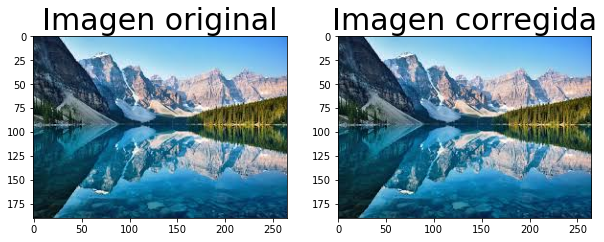

In [7]:
OjosRojos('paisaje.jpg').comparar()

### Animales

#### Imagen de un perro

Por favor seleccione con rectángulos azules las zonas de la imagen donde se encuentran los ojos (click izquierdo y arrastrar). 
         Tras seleccionar cada ojo, presione la tecla enter. Cuando termine de seleccionar, presione escape.


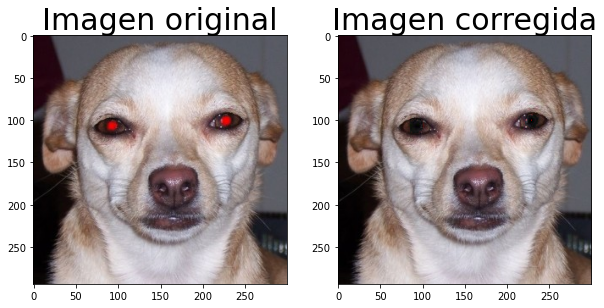

In [10]:
OjosRojos('ojos_rojos4.jpg').comparar(modo_manual=True)

#### Imagen de un gato

Por favor seleccione con rectángulos azules las zonas de la imagen donde se encuentran los ojos (click izquierdo y arrastrar). 
         Tras seleccionar cada ojo, presione la tecla enter. Cuando termine de seleccionar, presione escape.


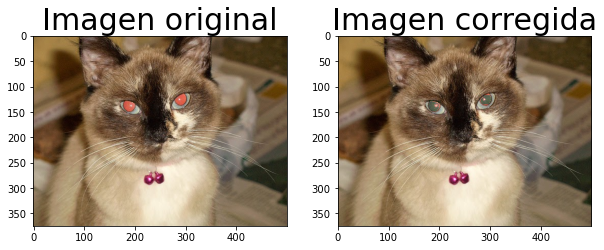

In [11]:
OjosRojos('ojos_rojos3.jpg').comparar(modo_manual=True)

## Fuentes

[1] Japskua. (2010). REMOVING RED EYES WITH OPENCV AND PYTHON. Retrieved from https://japskua.wordpress.com/2010/08/05/removing-red-eyes-with-opencv-and-python/